# Compressive sensing example


In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load example image

In [2]:
def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        return img[starty:starty+cropy,startx:startx+cropx]
    if len(img.shape) == 3:
        return img[0,starty:starty+cropy,startx:startx+cropx]

path = './test_data/'
img_name = "chili"
#img_path = path + "tomato_mri.jpg"
img_path = path + "chili.jpg"



img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

#img_np_small = np.array([crop_center(img_np[0],128,128)])
img_np_small = np.array([crop_center(img_np[0],256,256)])
print(img_np_small.shape)

img_var = np_to_var(img_np_small).type(dtype)
output_depth = img_np.shape[0]

(1, 256, 256)


## Define forward model

In [3]:
X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/4)
A = torch.empty(n,m).uniform_(-1, 1).type(dtype)
A *= 1/np.sqrt(m)

def forwardm(img_var):
    X = img_var.view(-1 , np.prod(img_var.shape) ) 
    return torch.mm(X,A)

measurement = forwardm(img_var)

## DD reconstruction and helper functions

In [4]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [5]:
def dd_recovery(measurement,img_var,num_channnels,num_iter=100000,apply_f=forwardm,ni=None):
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    #net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                                net_input=ni,
                        reg_noise_std=0.0,num_iter=num_iter,
                        OPTIMIZER='SGD',
                        LR = 0.005, #LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = apply_f,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var, mse_n, mse_t

## Example reconstruction

In [6]:
#num_channels = [256]*4
#num_channels = [512]*5
num_channels = [384]*5

measurement = forwardm(img_var).type(dtype)
out_img_var, mse_n, mse_t = dd_recovery(measurement,img_var,num_channels)

input shape:  [1, 384, 8, 8]
optimize with SGD 0.005
889728ion 99990    Train loss 0.000031  Actual loss 0.004962 Actual loss orig 0.004962 


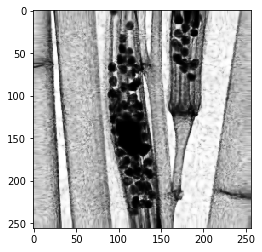

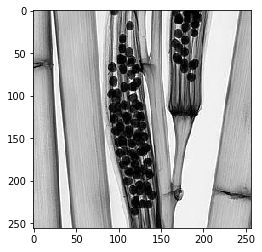

0.10356331


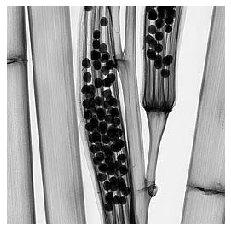

In [7]:
orig_img = img_var.data.cpu().numpy()[0,0]
rec_img = out_img_var.data.cpu().numpy()[0,0]

plt.imshow(rec_img,cmap='gray')
plt.show()
plt.imshow(orig_img,cmap='gray')
plt.show()


print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')


    
savefig(img_name + '_orig.png',img_var.data.cpu().numpy()[0,0])

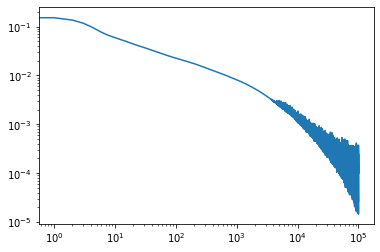

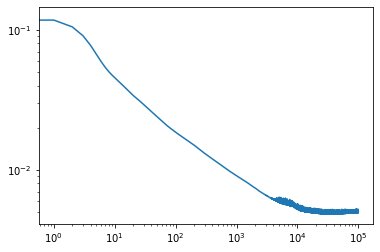

In [8]:
plt.loglog(mse_n)
plt.show()
plt.loglog(mse_t)
plt.show()

In [9]:
R = np.vstack( (np.array([k for k in range(len(mse_n))]),mse_n,mse_t) ).T
R.shape

(100000, 3)

In [10]:
def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=1000)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

## save results 
savemtx_for_logplot( R.T, "CS_convergence.dat")